# Team Case Studies

This notebook performs deep-dive case studies on 2-3 selected teams.

We will:
- Load raw data and add opponent/zone columns
- Analyze offense patterns (main attacking zones, pass success rates, shot locations)
- Analyze defense patterns (dangerous zones, opponent pass success, goals conceded)
- Generate text insights and visualizations for each team


In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import project modules
from src.data_loader import load_raw_events, load_match_info
from src.feature_engineering import add_zone_columns
from src.case_study import (
    add_opponent_columns,
    summarize_team_case_study,
    generate_text_insights,
)
from src.pitch_plot import draw_pitch, plot_events_scatter, simple_kde_heatmap

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


## 1. 데이터 로딩 & opponent/zone 추가


In [2]:
# Load raw data
events = load_raw_events()
match_info = load_match_info()

print(f"Events loaded: {len(events):,}")
print(f"Matches: {len(match_info):,}")

# Add opponent columns
events = add_opponent_columns(events, match_info)

# Add zone columns
events = add_zone_columns(events, x_col="start_x", y_col="start_y")

print(f"\nEvents with zones: {len(events):,}")
print(f"Columns: {list(events.columns)}")


Events loaded: 579,306
Matches: 198

Events with zones: 579,306
Columns: ['game_id', 'action_id', 'period_id', 'time_seconds', 'team_id', 'player_id', 'result_name', 'start_x', 'start_y', 'end_x', 'end_y', 'dx', 'dy', 'type_name', 'player_name_ko', 'team_name_ko', 'position_name', 'main_position', 'home_team_id', 'away_team_id', 'home_team_name_ko', 'away_team_name_ko', 'opponent_team_name_ko', 'zone_x', 'zone_y', 'zone']


## 2. 분석할 팀 리스트 설정


In [3]:
# 분석 대상 팀 (한글 이름 기준)
TARGET_TEAMS = [
    "울산 HD FC",      # 상위권, 공격/수비 밸런스형
    "FC서울",          # 공격 패턴 뚜렷한 팀
    "강원FC",          # 상대적으로 실점/압박에서 약점이 나올 수 있는 팀
]

# 사용 가능한 팀 목록 확인
available_teams = sorted(events["team_name_ko"].dropna().unique())
print("사용 가능한 팀 목록:")
for team in available_teams:
    print(f"  - {team}")

print(f"\n분석 대상 팀: {TARGET_TEAMS}")

# 팀 존재 여부 확인
for team in TARGET_TEAMS:
    if team not in available_teams:
        print(f"⚠️ 경고: '{team}'이(가) 데이터에 없습니다.")


사용 가능한 팀 목록:
  - FC서울
  - 강원FC
  - 광주FC
  - 김천 상무 프로축구단
  - 대구FC
  - 대전 하나 시티즌
  - 수원FC
  - 울산 HD FC
  - 인천 유나이티드
  - 전북 현대 모터스
  - 제주SK FC
  - 포항 스틸러스

분석 대상 팀: ['울산 HD FC', 'FC서울', '강원FC']


## 3. 팀별 케이스 스터디 실행


In [4]:
team_summaries = {}

for team_ko in TARGET_TEAMS:
    print("=" * 80)
    print(f"[케이스 스터디] {team_ko}")
    print("=" * 80)
    
    # 팀이 데이터에 있는지 확인
    if team_ko not in events["team_name_ko"].values:
        print(f"⚠️ '{team_ko}' 데이터가 없어 건너뜁니다.\n")
        continue
    
    summary = summarize_team_case_study(events, team_ko)
    team_summaries[team_ko] = summary
    
    offense = summary["offense"]
    defense = summary["defense"]
    
    insights = generate_text_insights(offense, defense)
    
    print("\n[공격 인사이트]")
    for line in insights["offense"]:
        print("  -", line)
    
    print("\n[수비 인사이트]")
    for line in insights["defense"]:
        print("  -", line)
    
    print("\n")


[케이스 스터디] 울산 HD FC

[공격 인사이트]
  - 공격 이벤트 총 53,492회, 그 중 패스 17,272회, 슛 374회, 득점 47골
  - 유효슈팅 159회
  - 주요 공격 지역: A-C (슈팅 162회, 골 29골), D-C (슈팅 129회, 골 14골), A-L (슈팅 23회, 골 0골)
  - 패스 성공률이 높은 존: nan-L (성공률 100.0%, 시도 1회), AM-C (성공률 92.5%, 시도 1977회), DM-C (성공률 91.5%, 시도 1911회)

[수비 인사이트]
  - 상대 공격 이벤트를 총 44,700회 허용, 그 중 슛 333회, 실점 30골
  - 상대에게 자주 슛을 허용하는 지역: D-C (슈팅 116회, 실점 15골), A-C (슈팅 103회, 실점 13골), A-R (슈팅 25회, 실점 0골)


[케이스 스터디] FC서울

[공격 인사이트]
  - 공격 이벤트 총 50,233회, 그 중 패스 15,869회, 슛 346회, 득점 47골
  - 유효슈팅 139회
  - 주요 공격 지역: A-C (슈팅 143회, 골 22골), D-C (슈팅 119회, 골 20골), A-R (슈팅 19회, 골 2골)
  - 패스 성공률이 높은 존: D-nan (성공률 100.0%, 시도 2회), DM-nan (성공률 100.0%, 시도 10회), nan-L (성공률 100.0%, 시도 1회)

[수비 인사이트]
  - 상대 공격 이벤트를 총 46,040회 허용, 그 중 슛 333회, 실점 32골
  - 상대에게 자주 슛을 허용하는 지역: A-C (슈팅 139회, 실점 17골), D-C (슈팅 106회, 실점 13골), D-R (슈팅 22회, 실점 2골)


[케이스 스터디] 강원FC

[공격 인사이트]
  - 공격 이벤트 총 48,150회, 그 중 패스 14,825회, 슛 371회, 득점 51골
  - 유효슈팅 145회
  - 주요 공격 지역: A-C (슈팅 157회, 골 30골), D-C (슈팅 113회, 골 16골), A-L

## 4. 시각화 함수 정의


In [5]:
def plot_team_offense_heatmaps(events_with_zone, team_name_ko):
    """팀의 공격 이벤트와 슛 위치 히트맵을 그립니다."""
    team_events = events_with_zone[events_with_zone["team_name_ko"] == team_name_ko]
    
    if len(team_events) == 0:
        print(f"⚠️ '{team_name_ko}'의 데이터가 없습니다.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 10))
    
    # 전체 공격 이벤트 밀도
    ax = axes[0]
    draw_pitch(ax=ax, show=False)
    simple_kde_heatmap(
        team_events,
        ax=ax,
        x_col="start_x",
        y_col="start_y",
        draw_pitch_flag=False,
        show_colorbar=True,
    )
    ax.set_title(f"{team_name_ko} - 전체 공격 이벤트 밀도", fontsize=14, fontweight="bold")
    
    # 슛 위치 히트맵
    shots = team_events[team_events["type_name"] == "Shot"]
    ax = axes[1]
    draw_pitch(ax=ax, show=False)
    if len(shots) > 0:
        simple_kde_heatmap(
            shots,
            ax=ax,
            x_col="start_x",
            y_col="start_y",
            draw_pitch_flag=False,
            show_colorbar=True,
        )
        ax.set_title(f"{team_name_ko} - 슛 위치 밀도", fontsize=14, fontweight="bold")
    else:
        ax.set_title(f"{team_name_ko} - 슛 위치 밀도 (데이터 없음)", fontsize=14)
    
    plt.tight_layout()
    plt.show()


def plot_team_defense_heatmaps(events_with_zone, team_name_ko):
    """팀의 수비 관점에서 상대 공격 이벤트와 슛 위치 히트맵을 그립니다."""
    opp_events = events_with_zone[events_with_zone["opponent_team_name_ko"] == team_name_ko]
    
    if len(opp_events) == 0:
        print(f"⚠️ '{team_name_ko}'에 대한 상대 공격 데이터가 없습니다.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 10))
    
    # 상대 공격 이벤트 밀도
    ax = axes[0]
    draw_pitch(ax=ax, show=False)
    simple_kde_heatmap(
        opp_events,
        ax=ax,
        x_col="start_x",
        y_col="start_y",
        draw_pitch_flag=False,
        show_colorbar=True,
        cmap="Blues",
    )
    ax.set_title(f"{team_name_ko} - 상대 공격 이벤트 밀도 (수비 관점)", fontsize=14, fontweight="bold")
    
    # 상대 슛 위치 히트맵
    opp_shots = opp_events[opp_events["type_name"] == "Shot"]
    ax = axes[1]
    draw_pitch(ax=ax, show=False)
    if len(opp_shots) > 0:
        simple_kde_heatmap(
            opp_shots,
            ax=ax,
            x_col="start_x",
            y_col="start_y",
            draw_pitch_flag=False,
            show_colorbar=True,
            cmap="Reds",
        )
        ax.set_title(f"{team_name_ko} - 상대 슛 위치 밀도 (위험 지역)", fontsize=14, fontweight="bold")
    else:
        ax.set_title(f"{team_name_ko} - 상대 슛 위치 밀도 (데이터 없음)", fontsize=14)
    
    plt.tight_layout()
    plt.show()


## 5. 팀별 시각화



====== 울산 HD FC 시각화 ======



C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) Arial.
  plt.tight_layou

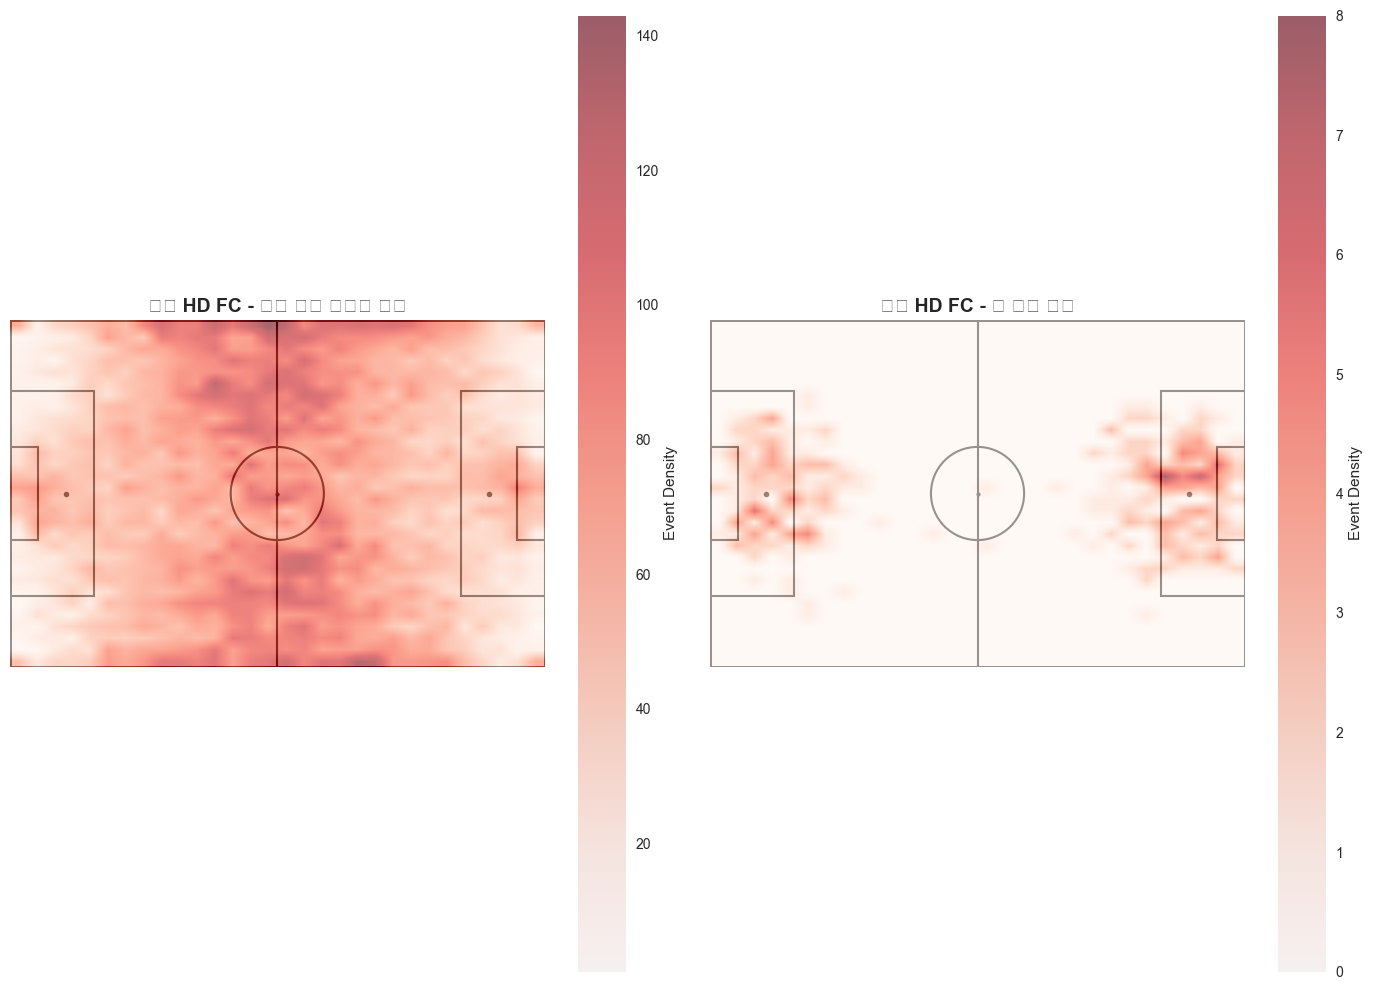

C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) Arial.
  plt.tight_layo

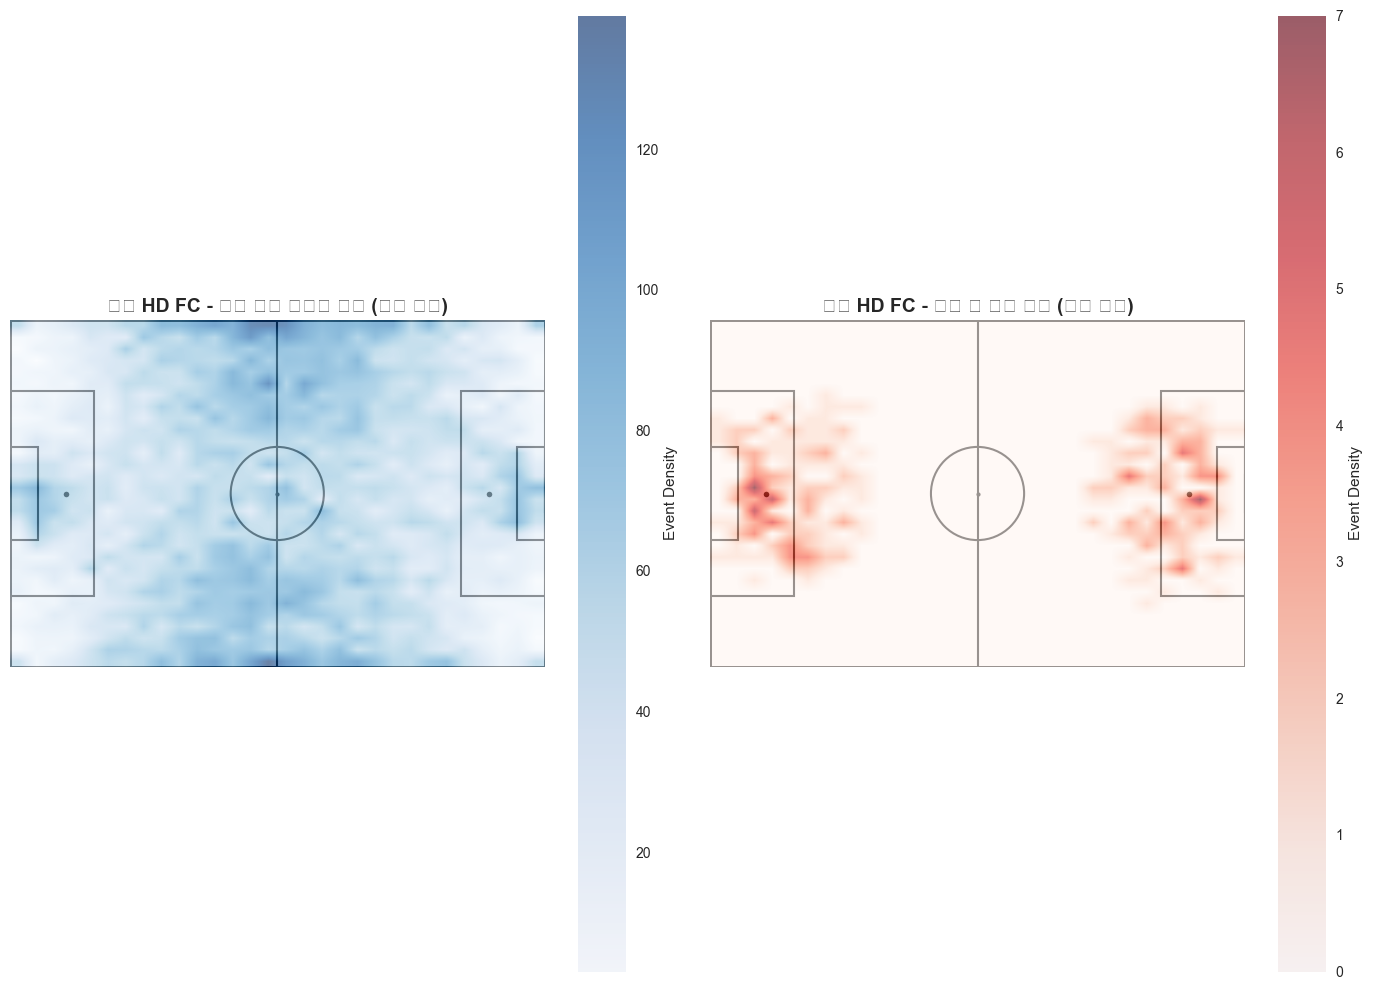


====== FC서울 시각화 ======



C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) Arial.
  plt.tight_layou

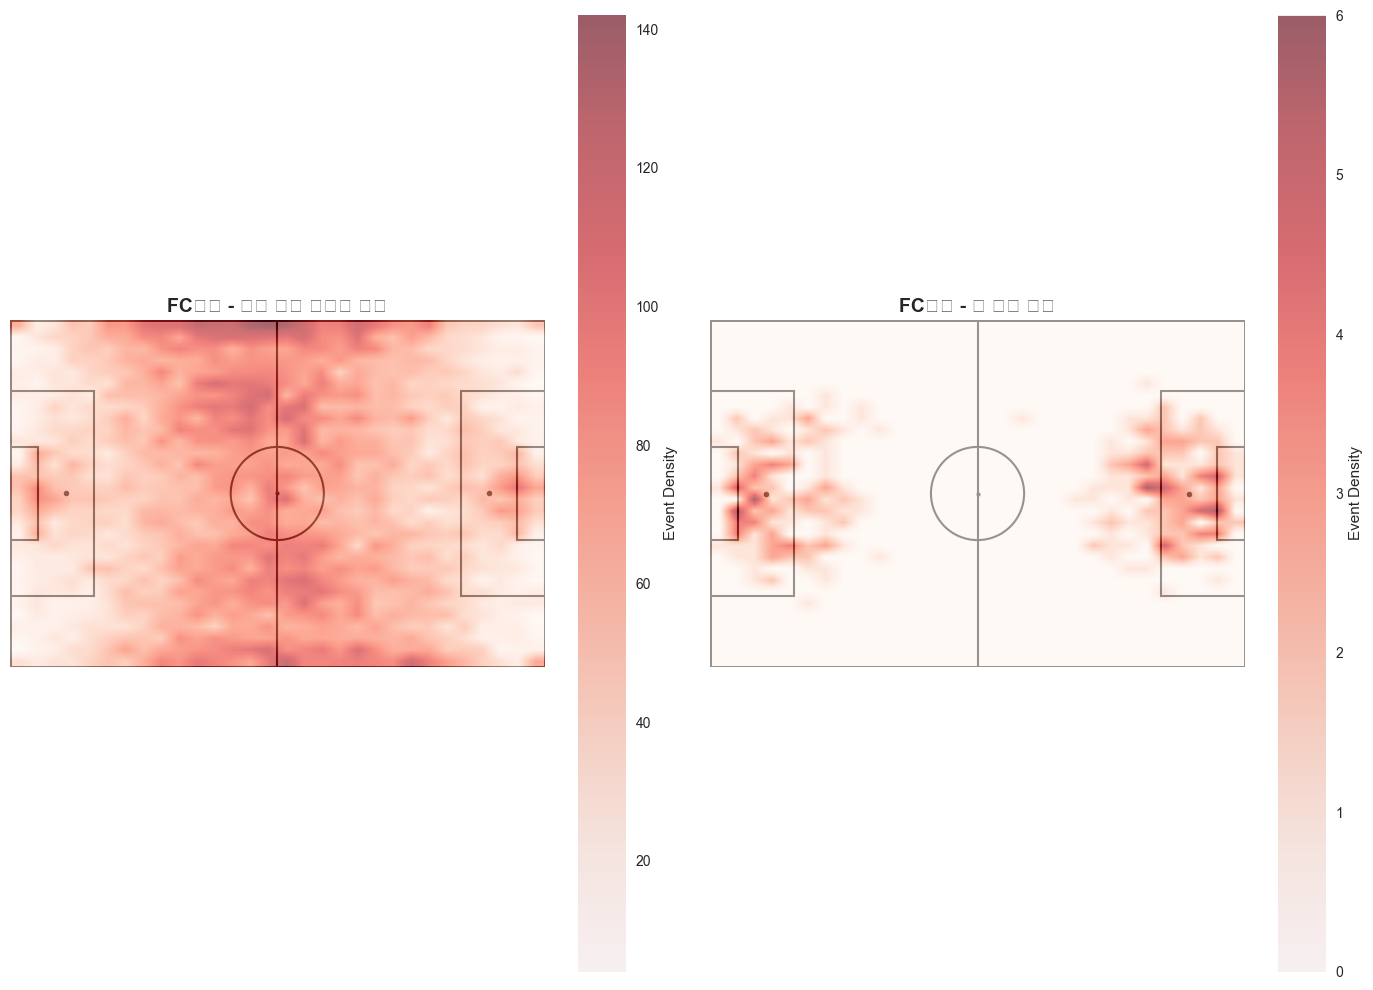

C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) Arial.
  plt.tight_layo

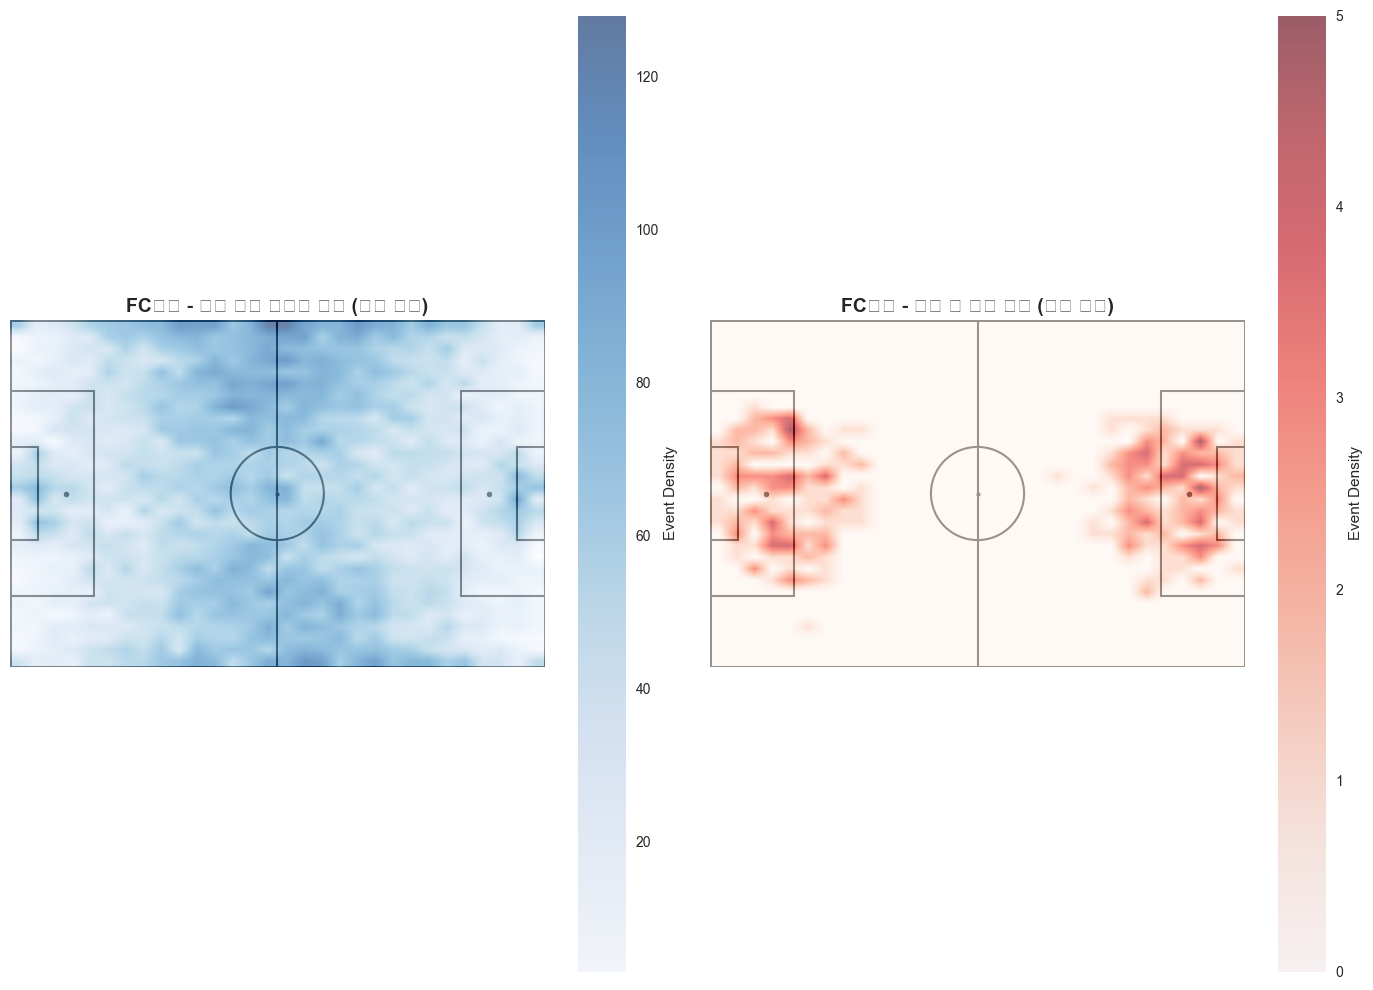


====== 강원FC 시각화 ======



C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:41: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) Arial.
  plt.tight_la

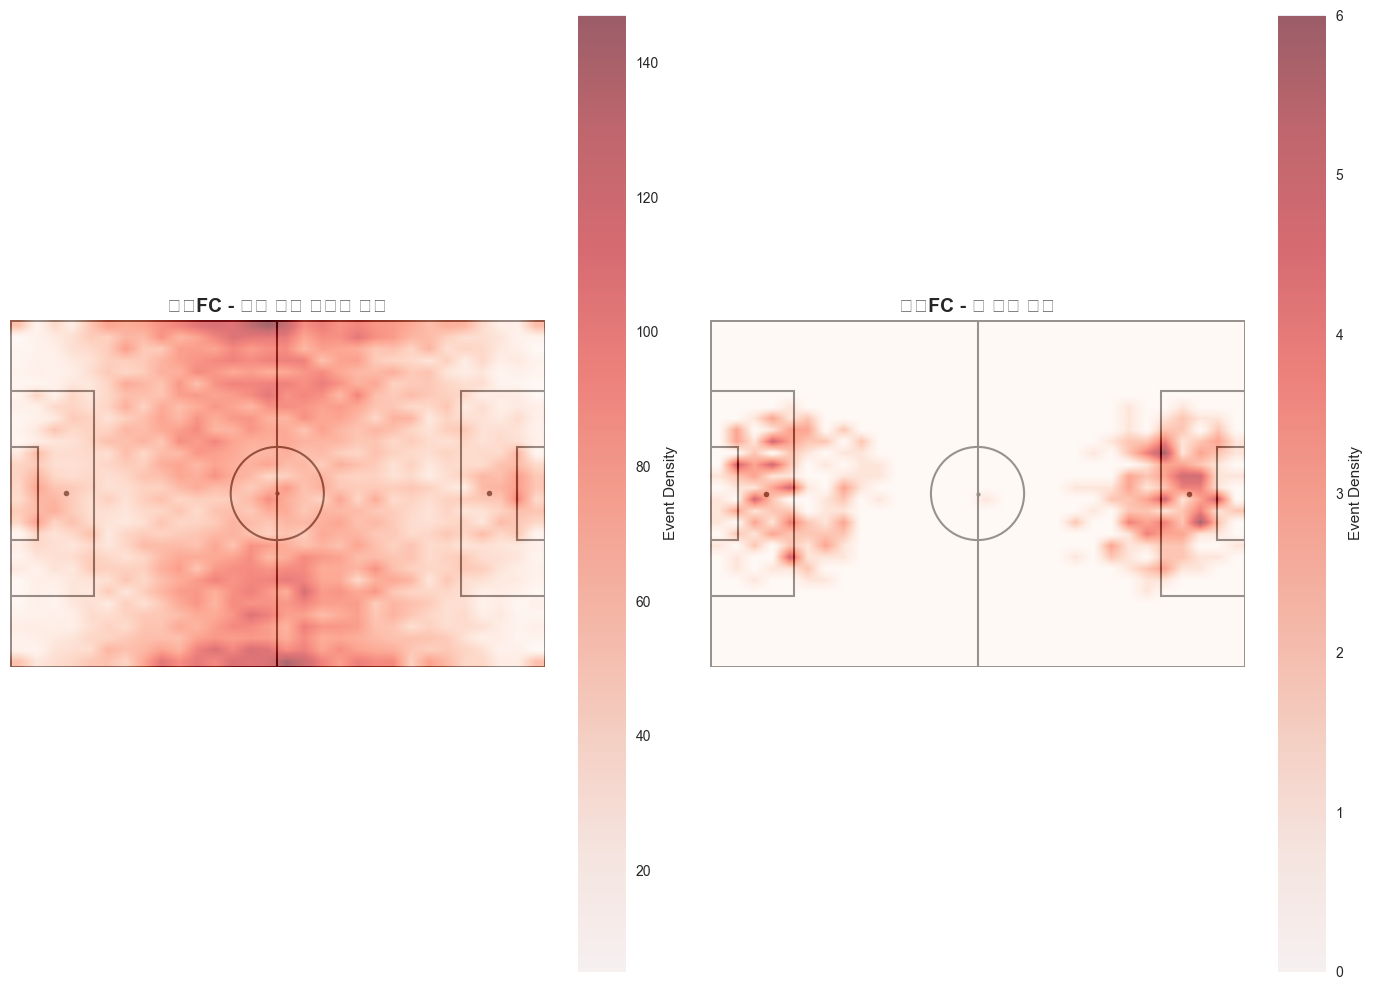

C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_40072\208728103.py:87: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) Arial.
  plt.tight_l

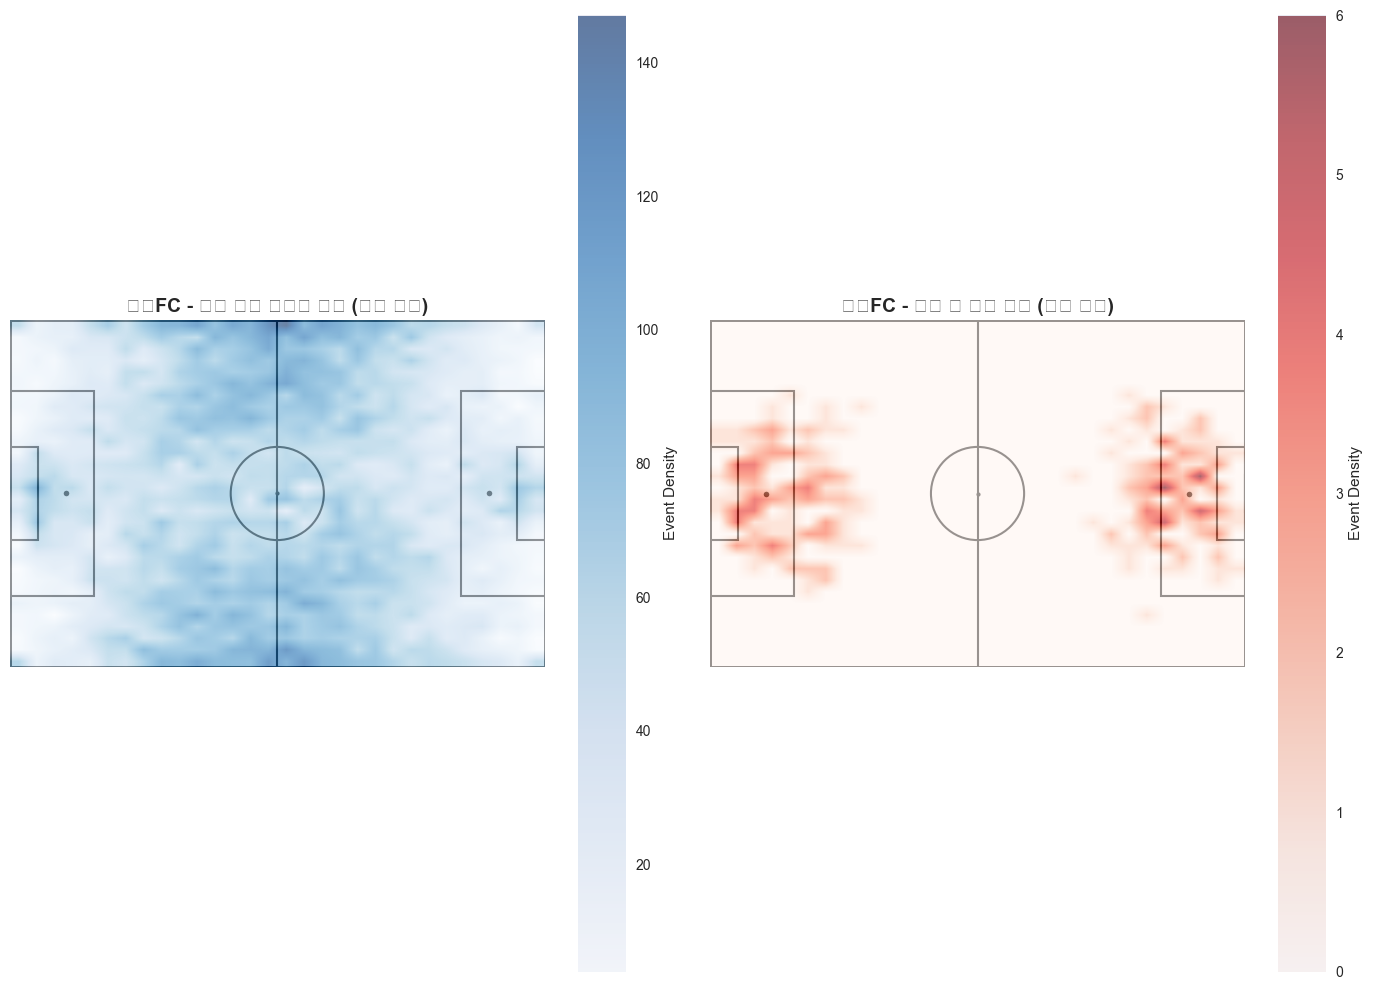

In [6]:
for team_ko in TARGET_TEAMS:
    if team_ko not in team_summaries:
        continue
    
    print(f"\n{'='*80}")
    print(f"====== {team_ko} 시각화 ======")
    print(f"{'='*80}\n")
    
    # 공격 히트맵
    plot_team_offense_heatmaps(events, team_ko)
    
    # 수비 히트맵
    plot_team_defense_heatmaps(events, team_ko)


## 6. 상세 통계 요약표


In [7]:
# 팀별 주요 통계를 DataFrame으로 정리
summary_data = []

for team_ko, summary in team_summaries.items():
    offense = summary["offense"]
    defense = summary["defense"]
    
    summary_data.append({
        "팀명": team_ko,
        "공격 이벤트": offense.n_actions,
        "패스": offense.n_passes,
        "슛": offense.n_shots,
        "득점": offense.n_goals,
        "유효슈팅": offense.shot_on_target,
        "상대 공격 허용": defense.n_actions_faced,
        "상대 슛 허용": defense.n_opponent_shots,
        "실점": defense.n_goals_conceded,
    })

summary_df = pd.DataFrame(summary_data)
print("팀별 주요 통계:")
print(summary_df.to_string(index=False))


팀별 주요 통계:
      팀명  공격 이벤트    패스   슛  득점  유효슈팅  상대 공격 허용  상대 슛 허용  실점
울산 HD FC   53492 17272 374  47   159     44700      333  30
    FC서울   50233 15869 346  47   139     46040      333  32
    강원FC   48150 14825 371  51   145     47931      297  41


In [8]:
# 각 팀의 주요 공격 지역 상세
for team_ko, summary in team_summaries.items():
    offense = summary["offense"]
    print(f"\n{'='*60}")
    print(f"{team_ko} - 주요 공격 지역")
    print(f"{'='*60}")
    if len(offense.main_attacking_zones) > 0:
        print(offense.main_attacking_zones.to_string(index=False))
    else:
        print("데이터 없음")



울산 HD FC - 주요 공격 지역
zone  shot_attempts  goals
 A-C            162     29
 D-C            129     14
 A-L             23      0
 D-R             18      0
 A-R             17      4

FC서울 - 주요 공격 지역
zone  shot_attempts  goals
 A-C            143     22
 D-C            119     20
 A-R             19      2
 D-R             18      0
 D-L             17      2

강원FC - 주요 공격 지역
zone  shot_attempts  goals
 A-C            157     30
 D-C            113     16
 A-L             20      2
 D-R             19      1
DM-C             18      0


In [9]:
# 각 팀의 위험 지역 상세
for team_ko, summary in team_summaries.items():
    defense = summary["defense"]
    print(f"\n{'='*60}")
    print(f"{team_ko} - 위험 지역 (상대 슛 허용)")
    print(f"{'='*60}")
    if len(defense.dangerous_zones) > 0:
        print(defense.dangerous_zones.to_string(index=False))
    else:
        print("데이터 없음")



울산 HD FC - 위험 지역 (상대 슛 허용)
zone  shot_attempts_against  goals_conceded
 D-C                    116              15
 A-C                    103              13
 A-R                     25               0
 A-L                     22               1
 D-L                     22               0

FC서울 - 위험 지역 (상대 슛 허용)
zone  shot_attempts_against  goals_conceded
 A-C                    139              17
 D-C                    106              13
 D-R                     22               2
 D-L                     19               0
 A-L                     15               0

강원FC - 위험 지역 (상대 슛 허용)
zone  shot_attempts_against  goals_conceded
 D-C                    115              18
 A-C                    112              21
 D-R                     16               0
 D-L                     15               0
 A-R                     14               0
